<a href="https://colab.research.google.com/github/constructor-s/aps1080_winter_2021/blob/main/A3/A3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A3: TD(n) and Mountain Car
==========================

Submit Assignment

*   Due Tuesday by 11:59pm
*   Points 100
*   Submitting a file upload
*   File Types pdf

In this assignment we are going to apply the TD(n) methods to solve the Mountain Car problem.

By now, you should know how to load OpenAI gym environments:

env = gym.make('MountainCar-v0')



In [14]:
#%% Set up rendering

# from pyvirtualdisplay import Display
# display = Display(visible=False, size=(400, 300))
# display.start()

In [15]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import *
from IPython.display import clear_output

env = gym.make('MountainCar-v0')

Exercise 1: Prelims
-------------------

These are useful exercises to develop facility with the environment prior to the graded component of the assignment. Explore the above environment as we've done in past assignments and exercises.

Develop a MC controller and assess its performance.


In [16]:
#%% Set up the environment
"""
Reference:

Description:
    The agent (a car) is started at the bottom of a valley. For any given
    state the agent may choose to accelerate to the left, right or cease
    any acceleration.
Source:
    The environment appeared first in Andrew Moore's PhD Thesis (1990).
Observation:
    Type: Box(2)
    Num    Observation               Min            Max
    0      Car Position              -1.2           0.6
    1      Car Velocity              -0.07          0.07
Actions:
    Type: Discrete(3)
    Num    Action
    0      Accelerate to the Left
    1      Don't accelerate
    2      Accelerate to the Right
    Note: This does not affect the amount of velocity affected by the
    gravitational pull acting on the car.
Reward:
        Reward of 0 is awarded if the agent reached the flag (position = 0.5)
        on top of the mountain.
        Reward of -1 is awarded if the position of the agent is less than 0.5.
Starting State:
        The position of the car is assigned a uniform random value in
        [-0.6 , -0.4].
        The starting velocity of the car is always assigned to 0.
Episode Termination:
        The car position is more than 0.5
        Episode length is greater than 200
"""

def obs2state(obs):
    """
    Discretize observations to states
    """
    digitized = [np.searchsorted(bins, o, "right") 
            for o, bins in zip(obs, obs2state.bin_divide)]
    return (digitized * obs2state.multiplier).sum()
obs2state.bin_divide = (
        (-0.3, +0.0, +0.3),
        (+0.0, ),
)
obs2state.multiplier = np.concatenate([[1], 
                    np.cumprod([len(i)+1 for i in obs2state.bin_divide[:-1]])])
obs2state.S = np.product([len(i)+1 for i in obs2state.bin_divide])


def run_env(policy_fun, # obs2state=obs2state, 
            env=gym.make('MountainCar-v0'), max_iter=1000, 
            debug=False, plot=False):
    """
    Simulate episodes of the environment

    Parameters
    ------------------
    policy_fun : function
        A function that maps observation to valid action

    Yields
    ------------------
    O_t, A_t, R_t+1, O_t+1, A_t+1, done
        SARSA pairs. O is the observation.
    """
    if plot:
        fig, ax = plt.subplots(2, 5, figsize=(11, 8.5))
    obs = env.reset() # ; s = obs2state(obs)
    a = policy_fun(obs)
    for i in range(max_iter):
        next_obs, r, done, info = env.step(a) #; next_s = obs2state(next_obs)
        next_a = policy_fun(next_obs)
        yield obs, a, r, next_obs, next_a, done
        if plot and i%20 == 19:
            ax.ravel()[i // 20].imshow(env.render(mode='rgb_array'))
            ax.ravel()[i // 20].set_title(
                f"Step {i}, obs =\n{np.array2string(obs, precision=1)}")
        if debug and done:
            print(f"Observation at i = {i}: {obs}")
        obs, a = next_obs, next_a
        if done:
            if debug:
                print(f"Observation at terminal: {obs}")
            if plot:
                ax.ravel()[-1].imshow(env.render(mode='rgb_array'))
                ax.ravel()[-1].set_title(
                    f"Step {i}, obs =\n{np.array2string(obs, precision=1)}")
            break
    env.close()

print("Generating a random episode:")
rng = np.random.RandomState(0)
pd.DataFrame(run_env(lambda _: rng.randint(3), plot='display' in globals()),
             columns=["O_t", "A_t", "R_t+1", "O_t+1", "A_t+1", "done"])

Generating a random episode:


,O_t,A_t,R_t+1,O_t+1,A_t+1,done
0,"[-0.4873005318493257, 0.0]",0,-1.0,"[-0.4885722309628013, -0.0012716991134755563]",1,False
1,"[-0.4885722309628013, -0.0012716991134755563]",1,-1.0,"[-0.4901061459858374, -0.0015339150230361265]",0,False
2,"[-0.4901061459858374, -0.0015339150230361265]",0,-1.0,"[-0.49289083327540506, -0.0027846872895676304]",1,False
3,"[-0.49289083327540506, -0.0027846872895676304]",1,-1.0,"[-0.4959055045054149, -0.003014671230009834]",1,False
4,"[-0.4959055045054149, -0.003014671230009834]",1,-1.0,"[-0.4991276364185299, -0.003222131913115038]",2,False
...,...,...,...,...,...,...
195,"[-0.5139365606166415, 0.022309545333727563]",1,-1.0,"[-0.4916994717476524, 0.022237088868989105]",2,False
196,"[-0.4916994717476524, 0.022237088868989105]",2,-1.0,"[-0.4687012626538396, 0.0229982090938128]",0,False
197,"[-0.4687012626538396, 0.0229982090938128]",0,-1.0,"[-0.4471129261547602, 0.021588336499079385]",0,False
198,"[-0.4471129261547602, 0.021588336499079385]",0,-1.0,"[-0.42709321296332603, 0.02001971319143421]",1,False


In [17]:
#%% General training template

def train(step_update_fun,
        alpha = 0.5,
        eps = 0.001,
        gamma = 0.9,
        num_S = obs2state.S,
        num_A = env.action_space.n,
        seed = 0,
        n_training_episodes = 10000):
    """
    Generic template for training of tabular methods. 
    Training can be monitoring through a plot and be interrupted at any time.

    Parameters:
    ----------------
    step_update_fun : function
        Function with inputs: List[s, a, r, s_, a_, done], Q, alpha, gamma
        Called after each step is made. 
        The last call with be with done == True.

    Returns:
    ----------------
    locals() : 
        All local variables in this training function
    """
    rng = np.random.RandomState(seed)
    Q = rng.random([num_S, num_A]); assert (Q > 0).all()

    training_hist = []
    testing_hist = []
    try:
        for episode_i in range(n_training_episodes):
            # On-the-fly eps-soft policy based on Q
            policy_fun = lambda s: rng.choice(
                (np.argmax(Q[obs2state(s)]), rng.randint(num_A)), 
                p=(1-eps, eps))
            
            episode = []
            for step_i, (o, a, r, o_, a_, done) in enumerate(
                                                run_env(policy_fun)):
                s, s_ = obs2state(o), obs2state(o_)
                episode.append((s, a, r, s_, a_, done))
                step_update_fun(episode, Q, alpha, gamma)

            # Monitor training progress
            training_hist.append((episode_i, len(episode)))
            if episode_i % 50 == 0:
                # Test greedy policy
                testing_hist.append((episode_i, 
                    len(list(run_env(lambda o: np.argmax(Q[obs2state(o)]))))
                ))
                clear_output(wait=True)
                training_hist_ = np.array(training_hist)
                testing_hist_ = np.array(testing_hist)
                plt.plot(testing_hist_[:, 0], testing_hist_[:, 1], 'rx')
                plt.plot(training_hist_[:, 0], pd.Series(training_hist_[:, 1]).rolling(100).median(), "b-")
                plt.scatter(training_hist_[:, 0], training_hist_[:, 1], s=0.1, alpha=0.5, color="b")
                plt.legend(["Testing (greedy)",
                            "Training moving average", 
                            "Training (eps-soft)"])
                plt.xlabel("Training episode")
                plt.ylabel("Performance (steps)")
                plt.title("Training/Testing performance")
                plt.grid()
                plt.show()
                print(f"Training: Episode {episode_i} lasted {step_i} steps")
            ##
    except KeyboardInterrupt as e:
        print(e)
    finally:
        # Monitor training progress
        clear_output(wait=True)
        training_hist_ = np.array(training_hist)
        testing_hist_ = np.array(testing_hist)
        plt.plot(testing_hist_[:, 0], testing_hist_[:, 1], 'rx')
        plt.plot(training_hist_[:, 0], pd.Series(training_hist_[:, 1]).rolling(100).median(), "b-")
        plt.scatter(training_hist_[:, 0], training_hist_[:, 1], s=0.1, alpha=0.5, color="b")
        plt.legend(["Testing (greedy)",
                    "Training moving average", 
                    "Training (eps-soft)"])
        plt.xlabel("Training episode")
        plt.ylabel("Performance (steps)")
        plt.title("Training/Testing performance")
        plt.grid()
        plt.show()
        ##
        return locals()

S, A, R, S_, A_, DONE = 0, 1, 2, 3, 4, 5

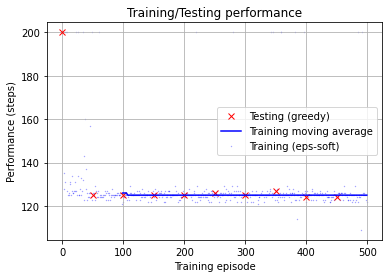

In [18]:
#%% Monte Carlo implementation - training

class monte_carlo_update():
    """
    Function that provides the Monte Carlo update at the end of the episode
    """
    def __init__(self):
        """
        Initialize the Returns dict to store the return history across episodes
        """
        self.Returns = defaultdict(lambda : defaultdict(list))

    def __call__(self, episode, Q, alpha, gamma):
        """
        Page 101, epsilon soft MC
        """
        # MC only updates after the entire episode is done
        if not episode[-1][DONE]:
            return
        else:
            G = 0
            sa_pairs = tuple([
                        (St, At) for St, At, Rt_1, St_1, At_1, done in episode])
            for t in reversed(range(len(episode))):
                St, At, Rt_1, St_1, At_1, done = episode[t]
                G = gamma * G + Rt_1
                if not (St, At) in sa_pairs[:t]:
                    self.Returns[St][At].append(G)
                    Q[St, At] = np.mean(self.Returns[St][At])

result = train(step_update_fun=monte_carlo_update(), gamma=0.999, eps = 0.001, 
                                            n_training_episodes=500)
globals().update(result)

In [19]:
#%% Monte Carlo testing

for i in range(10):
    episode = list(run_env(lambda o: np.argmax(Q[obs2state(o)]), plot=False))
    print(f"Testing episode ended in {len(episode)} steps at {episode[-1]}")

episode = list(run_env(lambda o: np.argmax(Q[obs2state(o)]), plot='display' in globals()))
print(f"Testing episode ended in {len(episode)} steps at {episode[-1]}")

Testing episode ended in 125 steps at (array([0.4821488, 0.0276126]), 2, -1.0, array([0.51045132, 0.02830252]), 2, True)
Testing episode ended in 125 steps at (array([0.49658631, 0.03058625]), 2, -1.0, array([0.52797018, 0.03138387]), 2, True)
Testing episode ended in 125 steps at (array([0.49921809, 0.03693391]), 2, -1.0, array([0.53696931, 0.03775122]), 2, True)
Testing episode ended in 125 steps at (array([0.47003004, 0.03104389]), 2, -1.0, array([0.50167389, 0.03164385]), 2, True)
Testing episode ended in 124 steps at (array([0.47801318, 0.03746903]), 2, -1.0, array([0.51614138, 0.0381282 ]), 2, True)
Testing episode ended in 124 steps at (array([0.49098112, 0.03499109]), 2, -1.0, array([0.52672797, 0.03574685]), 2, True)
Testing episode ended in 126 steps at (array([0.47917   , 0.03814699]), 2, -1.0, array([0.51798476, 0.03881476]), 2, True)
Testing episode ended in 126 steps at (array([0.46711519, 0.03692804]), 2, -1.0, array([0.50462163, 0.03750644]), 2, True)
Testing episode en


Task 1: TD(0)
-------------

Develop a TD(0) controller using:

*   on-policy SARSA
*   on-policy expected SARSA
*   off-policy expected SARSA with a greedy control policy.

Compare the performance of your controllers.

This will be graded.


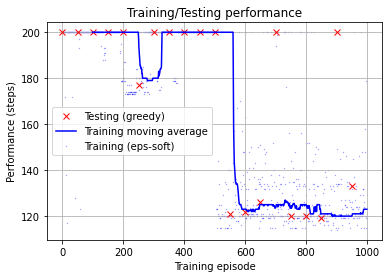

Testing episode ended in 129 steps at (array([0.49780351, 0.02342888]), 2, -1.0, array([0.52203912, 0.02423561]), 2, True)
Testing episode ended in 132 steps at (array([0.48707555, 0.02239194]), 2, -1.0, array([0.51019411, 0.02311856]), 2, True)
Testing episode ended in 120 steps at (array([0.4810645 , 0.03011186]), 2, -1.0, array([0.51185821, 0.03079372]), 2, True)
Testing episode ended in 121 steps at (array([0.47286394, 0.02726324]), 2, -1.0, array([0.50074814, 0.0278842 ]), 2, True)
Testing episode ended in 116 steps at (array([0.46656907, 0.0363787 ]), 2, -1.0, array([0.50352214, 0.03695306]), 2, True)
Testing episode ended in 119 steps at (array([0.47473271, 0.03643034]), 2, -1.0, array([0.51179787, 0.03706516]), 2, True)
Testing episode ended in 138 steps at (array([0.48635993, 0.01500232]), 2, -1.0, array([0.50208354, 0.01572361]), 2, True)
Testing episode ended in 125 steps at (array([0.48425456, 0.0265799 ]), 2, -1.0, array([0.51154006, 0.0272855 ]), 2, True)
Testing episode 

In [22]:
#%% On-policy TD(0) SARSA Training and Testing

# Training

def sarsa_update_fun(episode, Q, alpha, gamma, *args, **kwargs):
    """
    Page 130 SARSA
    """
    s, a, r, s_, a_, done = episode[-1]
    Q[s, a] = Q[s, a] + alpha * (r + gamma * Q[s_, a_] * (1-done) - Q[s, a])

result = train(step_update_fun=sarsa_update_fun, 
               gamma=0.999, eps = 0.0001, alpha=0.20, n_training_episodes=1000)
globals().update(result)

# Testing

for i in range(10):
    episode = list(run_env(lambda o: np.argmax(Q[obs2state(o)]), plot=False))
    print(f"Testing episode ended in {len(episode)} steps at {episode[-1]}")

episode = list(run_env(lambda o: np.argmax(Q[obs2state(o)]), plot='display' in globals()))
print(f"Testing episode ended in {len(episode)} steps at {episode[-1]}")

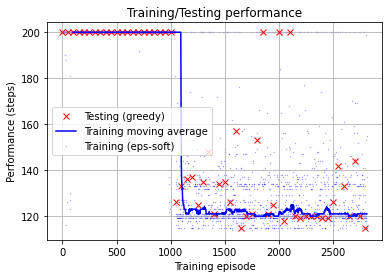

Testing episode ended in 132 steps at (array([0.4880075 , 0.02249307]), 2, -1.0, array([0.51123414, 0.02322664]), 2, True)
Testing episode ended in 115 steps at (array([0.46656907, 0.0363787 ]), 2, -1.0, array([0.50352214, 0.03695306]), 2, True)
Testing episode ended in 116 steps at (array([0.46656907, 0.0363787 ]), 2, -1.0, array([0.50352214, 0.03695306]), 2, True)
Testing episode ended in 120 steps at (array([0.49305133, 0.03001496]), 2, -1.0, array([0.52383751, 0.03078618]), 2, True)
Testing episode ended in 138 steps at (array([0.48445268, 0.01484331]), 2, -1.0, array([0.50000307, 0.01555039]), 2, True)
Testing episode ended in 143 steps at (array([0.48861156, 0.01262308]), 2, -1.0, array([0.50197271, 0.01336116]), 2, True)
Testing episode ended in 142 steps at (array([0.49115449, 0.01321926]), 2, -1.0, array([0.5051308 , 0.01397631]), 2, True)
Testing episode ended in 120 steps at (array([0.49452783, 0.03206053]), 2, -1.0, array([0.5273706 , 0.03284277]), 2, True)
Testing episode 

In [30]:
#%% Off-policy TD(0) expected SARSA with a greedy control policy 
# Training and Testing

# Training

def eSARSA_update_fun(episode, Q, alpha, gamma, *args, **kwargs):
    """
    Page 133

    Since pi is a greedy policy (i.e. p[np.argmax(Q[s_])] = 1.0 else 0.0)
    this is in effect identical to Q learning
    """
    s, a, r, s_, a_, done = episode[-1]
    p = np.zeros(Q.shape[1]); p[np.argmax(Q[s_])] = 1.0
    Q[s, a] = Q[s, a] + alpha * (r + gamma * (Q[s_] @ p) * (1-done) - Q[s, a])

result = train(step_update_fun=eSARSA_update_fun, 
               gamma=0.999, eps = 0.0001, alpha=0.20, n_training_episodes=2500)
globals().update(result)

# Testing

for i in range(10):
    episode = list(run_env(lambda o: np.argmax(Q[obs2state(o)]), plot=False))
    print(f"Testing episode ended in {len(episode)} steps at {episode[-1]}")

episode = list(run_env(lambda o: np.argmax(Q[obs2state(o)]), plot='display' in globals()))
print(f"Testing episode ended in {len(episode)} steps at {episode[-1]}")


Exercise 2: TD(n)
-----------------

A useful ungraded exercise. Develop code for TD(n) predication, n-step SARSA (on-policy) control and off-policy Tree Backup control.

Test it out.

Task 2: TD(2), TD(3), TD(4)
---------------------------

Code controllers for TD(2), TD(3), and TD(4) using n-SARSA. Assess performance and compare against TD(0) and each other.

You may choose to use your work from Ex 2 for this (if you did Ex 2); otherwise you can code specific solvers for TD(2/3/4).

Bonus Task 3: Tree Backup
-------------------------

This is optional; if you do this, your grade can exceed 100% and will offset other grades.

Assess the performance of Tree Backup for TD(2), TD(3), and TD(4) versus the respective n-SARSA controller.

Submission:
-----------

Submit a pdf containing your code --- in order --- and traces/logs indicating the controlling of the environment (instrument your code). Clearly include performance results (annotated with any parameters you chose). When asked to compare, show tables, and include discussion where needed to ensure your results are presented clearly. The TA can only grade what they see clearly presented; it is your responsibility to ensure this is the case. Follow the structure of the assignment spec.

1615953599 03/16/2021 11:59pm